### Preprocesamiento de datos 

Uno el titulo con el texto porque creo que, al ser el titulo mas corto, contiene mas palabras claves que pueden ser utiles y no tiene sentido trabajarlas por separado

In [39]:
def concat_columns(df, col1, col2, new_col):
    df[new_col] = df[col1].apply(str) + ' ' + df[col2].apply(str)
    df.drop(col2, axis = 1, inplace = True)
    return df

df_reviews_clean = concat_columns(df_reviews_clean, 'text', 'title', 'text')


In [40]:
df_reviews_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8306 entries, 0 to 8312
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   rating             8306 non-null   int64 
 1   text               8306 non-null   object
 2   helpful_vote       8306 non-null   int64 
 3   verified_purchase  8306 non-null   bool  
 4   length             8306 non-null   int64 
dtypes: bool(1), int64(3), object(1)
memory usage: 332.6+ KB


Convierto todos los caracteres de la columna 'text' a minusculas

In [42]:
# Conversion'text' a minúsculas
df_reviews_clean['text'] = df_reviews_clean['text'].str.lower()

Elimino caracteres especiales, numeros y stopwords

In [44]:
# Descargo stopwords 
nltk.download('stopwords')

# Cargo stopwords en ingles
stop_words = set(stopwords.words('english'))

# Funcion para limpiar el texto 
def limpiar_texto(texto):
    if not isinstance(texto, str):
        return ""
    
    # 1. Eliminar caracteres especiales y números (conserva letras y espacios)
    texto_limpio = re.sub(r'[^a-zA-ZáéíóúüñÁÉÍÓÚÜÑ\s]', '', texto)
    
    # 2. Eliminar stopwords
    palabras = texto_limpio.split()
    palabras_filtradas = [palabra for palabra in palabras if palabra not in stop_words]
    
    # 3. Unir palabras nuevamente
    return ' '.join(palabras_filtradas)

# Aplicar a la columna 'text'
df_reviews_clean['text_limpio'] = df_reviews_clean['text'].apply(limpiar_texto)

# Mostrar ejemplo antes/después
print("=== Ejemplo de limpieza ===")
print("Original:", df_reviews_clean['text'].iloc[0])
print("Limpio:", df_reviews_clean['text_limpio'].iloc[0])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vicky\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


=== Ejemplo de limpieza ===
Original: this spray is really nice. it smells really good, goes on really fine, and does the trick. i will say it feels like you need a lot of it though to get the texture i want. i have a lot of hair, medium thickness. i am comparing to other brands with yucky chemicals so i'm gonna stick with this. try it! such a lovely scent but not overpowering.
Limpio: spray really nice smells really good goes really fine trick say feels like need lot though get texture want lot hair medium thickness comparing brands yucky chemicals im gonna stick try lovely scent overpowering


In [45]:
# Elimino la columna 'text' original y conservo solo 'text_limpio'
df_reviews_clean = df_reviews_clean.drop(columns=['text'])

Guardo el dataset preprocesado en la carpeta 'data_sample/processed'

In [47]:
# Ruta ABSOLUTA 
ruta_destino = r'C:\Users\Vicky\Documents\ML_Amazon_Reviews_Analysis\data_sample\processed'

# Guardo el archivo
df_reviews_clean.to_csv(os.path.join(ruta_destino, 'reviews_preprocesadas.csv'), index=False)

print(f"¡Archivo guardado en: {ruta_destino}")

¡Archivo guardado en: C:\Users\Vicky\Documents\ML_Amazon_Reviews_Analysis\data_sample\processed


### Clasificacion del sentimiento

Reseñas positivas: rating >= 4

Reseñas neutras: rating == 3

Reseñas negativas: rating <= 2

In [49]:
# Clasificación basada en el rating
df_reviews_clean['sentimiento'] = pd.cut(
    df_reviews_clean['rating'],
    bins=[0, 2, 3, 5],  # Límites: <=2, ==3, >=4
    labels=['negativo', 'neutral', 'positivo'],
    right=True  # Incluye el límite superior (ej: 2.9 se redondea a negativo)
)

# Mostrar conteo de cada categoría
print(df_reviews_clean['sentimiento'].value_counts())

# Opcional: Filtrar ejemplos por categoría
print("\nEjemplo de reseña positiva:")
print(df_reviews_clean[df_reviews_clean['sentimiento'] == 'positivo'].sample(1)[['rating', 'text_limpio']].values)

print("\nEjemplo de reseña neutral:")
print(df_reviews_clean[df_reviews_clean['sentimiento'] == 'neutral'].sample(1)[['rating', 'text_limpio']].values)

print("\nEjemplo de reseña negativa:")
print(df_reviews_clean[df_reviews_clean['sentimiento'] == 'negativo'].sample(1)[['rating', 'text_limpio']].values)

sentimiento
positivo    6344
negativo    1139
neutral      823
Name: count, dtype: int64

Ejemplo de reseña positiva:
[[5 'really impressed nice price great pair buy']]

Ejemplo de reseña neutral:
[[3
  'youre dog owner practically guaranteed point deal dog dirty muddy paws happens often bichon mac naturally recently happened right cleaned mopped house lol ordered mr ros automatic cleaner smallmedium dogs sturdy durable flimsy roughly tall removable mat silicone bristles interior easily removable cleaning purposes bristles soft hard sharp arrived already charged usb cord included operate simply add water washer cups per instructions liquid soap may added well didnt use soap turn washer onit make noise though terribly loud alland place dogs paw washer minutes dry paw towel cleaning mac wasnt thrilled throughout cleaning process also wasnt really scared husband started pour dirty water could stop wont see much see photo water discolored bit following cleaning wet towel isnt enough clean 

### Tokenizacion del texto

In [51]:
import nltk
nltk.download('punkt') # es un modelo de tokenización basado en reglas que permite dividir un texto en palabras o frases.

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vicky\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

'word_tokenize'  es una función de nltk que divide un texto en palabras individuales (tokens), basada en Punkt, que es un modelo de tokenizacion

In [53]:
from nltk.tokenize import word_tokenize

df_reviews_clean['tokens'] = df_reviews_clean['text_limpio'].apply(lambda x: word_tokenize(str(x).lower()))


In [54]:
from sklearn.model_selection import train_test_split

# Dividir los datos en train (80%) y test (20%) 
# - estratificando por la columna 'sentimiento' (si existe)
# - semilla aleatoria (random_state) para reproducibilidad

train_df, test_df = train_test_split(
    df_reviews_clean,
    test_size=0.2,                # 20% para test
    random_state=42,              # semilla para reproducibilidad
    stratify=df_reviews_clean['sentimiento']  # mantiene proporción de clases
)

# Verificar tamaños
print(f"Train: {len(train_df)} muestras ({len(train_df)/len(df_reviews_clean)*100:.1f}%)")
print(f"Test: {len(test_df)} muestras ({len(test_df)/len(df_reviews_clean)*100:.1f}%)")

# Verificar distribución de clases en train y test (si es clasificación)
print("\nDistribución en Train:")
print(train_df['sentimiento'].value_counts(normalize=True))

print("\nDistribución en Test:")
print(test_df['sentimiento'].value_counts(normalize=True))

Train: 6644 muestras (80.0%)
Test: 1662 muestras (20.0%)

Distribución en Train:
sentimiento
positivo    0.763847
negativo    0.137116
neutral     0.099037
Name: proportion, dtype: float64

Distribución en Test:
sentimiento
positivo    0.763538
negativo    0.137184
neutral     0.099278
Name: proportion, dtype: float64


Como el dataset esta ampliamente desbalanceado, realizo algunas técnicas de balanceo del conjunto de entrenamiento.

Primero veo la distribución de clases

Distribución de clases:
 sentimiento
positivo    6344
negativo    1139
neutral      823
Name: count, dtype: int64


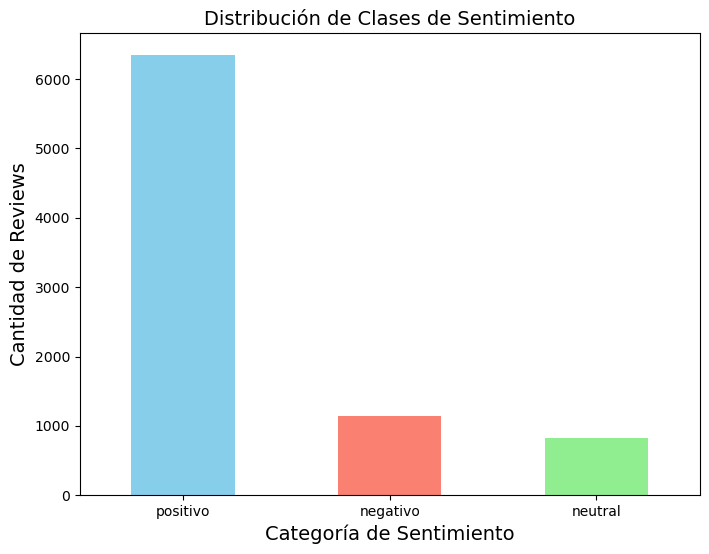

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Distribución de clases
class_dist = df_reviews_clean['sentimiento'].value_counts()
print("Distribución de clases:\n", class_dist)

# Gráfico
plt.figure(figsize=(8, 6))
class_dist.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Distribución de Clases de Sentimiento')
plt.xlabel('Categoría de Sentimiento')
plt.ylabel('Cantidad de Reviews')
plt.xticks(rotation=0)
plt.show()

### Tecnicas de balanceo

#### A. Random oversampling

In [58]:
from imblearn.over_sampling import RandomOverSampler

# Separar características y target
X = df_reviews_clean.drop('sentimiento', axis=1)
y = df_reviews_clean['sentimiento']

# Convertir variables categóricas a numéricas si es necesario
X = pd.get_dummies(X, columns=['verified_purchase'])

# Oversampling
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)

# Verificar nuevo balance
print("Nueva distribución:", Counter(y_res))

Nueva distribución: Counter({'positivo': 6344, 'negativo': 6344, 'neutral': 6344})


#### B. SMOTE

#### C. Ajuste de pesos en modelos (Class weight)

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Calcular pesos de clase
class_weights = dict(
    1 / df_reviews_clean['sentimiento'].value_counts(normalize=True)
)
